# 🧠 Classificazione di immagini con CNN

In questo notebook impareremo a:
-Scaricare e preparare un dataset di immagini di fiori.
-Effettuare il preprocessing (ridimensionamento, normalizzazione e suddivisione in training e validation set).
-Creare e addestrare una rete neurale convoluzionale (CNN) per riconoscere le diverse specie di fiori.
-Valutare le prestazioni del modello e visualizzare i risultati.

Useremo **TensorFlow e Keras**, librerie potenti e intuitive per il deep learning.

In [1]:
# Import principali librerie

import os                      # gestione di file e cartelle
import pathlib                 # gestione dei percorsi in modo più comodo
import random                  # generazione di numeri casuali (utile per shuffle)
import tarfile                 # apertura/estrazione archivi compressi .tar/.tgz

import numpy as np             # calcolo numerico e gestione matrici
import pandas as pd            # analisi e gestione di dati tabellari

import matplotlib.pyplot as plt# grafici e visualizzazione immagini

import tensorflow as tf        # deep learning e reti neurali
from tensorflow.keras.utils import load_img, img_to_array  # funzioni utili per le immagini

2025-10-07 07:08:12.767483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759820893.009879      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759820893.073591      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Verifichiamo se TensorFlow vede una GPU disponibile:
# - Se la lista è vuota [] significa che stai lavorando solo con la CPU
# - Se appare almeno un elemento, allora la GPU è attiva e potrà essere usata
print("GPU disponibili:", tf.config.list_physical_devices('GPU'))

GPU disponibili: []


2025-10-07 07:08:28.424476: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
# mostra i dataset/cartelle disponibili in /kaggle/input
print(os.listdir('/kaggle/input')) 

['flower-photos']


In [4]:
# Percorso al file compresso (.tgz) contenente il dataset dei fiori
data = '/kaggle/input/flower-photos/flower_photos.tgz'

# Cartella di destinazione dove verranno estratti i file
# /kaggle/working è lo spazio scrivibile a disposizione nel notebook Kaggle
extract_path = '/kaggle/working/flower_photos'

In [5]:
# Apriamo il file compresso con tarfile in modalità lettura gzip ('r:gz')
with tarfile.open(data, 'r:gz') as tar:
    # Estraiamo tutto il contenuto dentro la cartella di destinazione
    tar.extractall(extract_path)

In [6]:
# Con os.walk possiamo "camminare" dentro le cartelle e sottocartelle
# Restituisce: root (cartella corrente), dirs (sottocartelle), files (file presenti)

for root, dirs, files in os.walk(extract_path):
    # Calcoliamo la "profondità" della cartella attuale
    level = root.replace(extract_path, "").count(os.sep)

    # Creiamo l'indentazione (spazi) per rappresentare la gerarchia
    indent = " " * 2 * level

    # Stampiamo il nome della cartella con l'indentazione
    print(f"{indent}{os.path.basename(root)}/")

    # Prepariamo l'indentazione per i file (un livello più in basso rispetto alla cartella)
    subindent = " " * 2 * (level + 1)

    # Stampiamo solo i primi 3 file di ogni cartella per non avere output infinito
    for f in files[:3]:
        print(f"{subindent}{f}")

flower_photos/
  flower_photos/
    LICENSE.txt
    daisy/
      10466290366_cc72e33532.jpg
      15207766_fc2f1d692c_n.jpg
      6095817094_3a5b1d793d.jpg
    roses/
      12045735155_42547ce4e9_n.jpg
      8442304572_2fdc9c7547_n.jpg
      3109712111_75cea2dee6.jpg
    sunflowers/
      9783416751_b2a03920f7_n.jpg
      8929288228_6795bcb1fe.jpg
      3596902268_049e33a2cb_n.jpg
    dandelion/
      13471273823_4800ca8eec.jpg
      4893356345_24d67eff9f_m.jpg
      8739657154_6db14796c9.jpg
    tulips/
      2503489175_f0848d3e8e.jpg
      5603625247_e4ff1828af_m.jpg
      13289268363_b9337d751e.jpg


In [7]:
# Definiamo le classi del dataset di fiori.
# Ogni elemento rappresenta il nome di una cartella che contiene le immagini
# appartenenti a quella categoria. In questo caso il dataset è composto da 5 tipi di fiori:
# - daisy (margherite)
# - dandelion (soffioni)
# - roses (rose)
# - sunflowers (girasoli)
# - tulips (tulipani)
# Vengono salvati come byte string (b'...') perché TensorFlow lavora meglio
# con questo formato quando gestisce i dati testuali.
CLASSES = tf.constant([b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'])

In [8]:
# Definiamo il "pattern" (schema) per cercare tutte le immagini del dataset.
# Significa:
# - "flower_photos/"  → la cartella principale che contiene le sottocartelle
# - "*/"              → qualsiasi sottocartella (es: daisy, roses, ecc.)
# - "*.jpg"           → tutti i file con estensione .jpg
#
# In pratica, con questo pattern TensorFlow andrà a prendere tutte le immagini
# presenti in ogni sottocartella dentro "flower_photos/flower_photos".
PATTERN = 'flower_photos/flower_photos/*/*.jpg'

In [9]:
# Parametri principali per la preparazione del dataset di immagini

IMG_SIZE = 192   
# Tutte le immagini saranno ridimensionate a 192x192 pixel.
# È importante che abbiano la stessa dimensione per poter essere elaborate 
# in modo uniforme dalla rete neurale.

BATCH = 32
# Numero di immagini in ogni "batch" (lotto).
# I batch servono per allenare il modello poco alla volta, invece che con 
# tutte le immagini in una sola volta (che sarebbe troppo pesante in memoria).

AUTO = tf.data.AUTOTUNE
# Indica a TensorFlow di scegliere automaticamente il numero ottimale 
# di thread/processi per il caricamento e la preparazione dei dati,
# così da velocizzare l’allenamento senza doverlo decidere manualmente.

In [10]:
def decode_jpeg_and_label(filename):
    # 1. Leggo il contenuto grezzo del file immagine (in byte)
    bits = tf.io.read_file(filename)
    
    # 2. Decodifico il file JPEG e lo trasformo in un tensore immagine.
    #    channels=3 significa che mantengo i 3 canali RGB (colori).
    image = tf.image.decode_jpeg(bits, channels=3)
    
    # 3. Estraggo l'etichetta (label) dal percorso del file.
    #    L'immagine si trova in una sottocartella che indica la classe.
    #    Esempio:
    #    "flower_photos/roses/img123.jpg" → la label sarà "roses"
    label = tf.strings.split(tf.expand_dims(filename, -1), '/').values[-2]
    
    return image, label

In [11]:
def resize(image, label):
    # 1. Ridimensiono l’immagine alla dimensione fissa definita in IMG_SIZE (192x192).
    #    Tutte le immagini devono avere la stessa forma per poter entrare nella rete neurale.
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    
    # 2. Normalizzo i valori dei pixel:
    #    - tf.cast(..., tf.float32) → converte i valori in numeri decimali (float)
    #    - / 255.0 → porta i valori da [0, 255] (interi) a [0, 1] (decimali)
    #    Questo è importante perché i modelli di deep learning lavorano meglio con dati normalizzati.
    
    return tf.cast(image, tf.float32) / 255.0, label

In [12]:
def to_int_label(image, label):
    # 1. Converto la label testuale (es. b'roses') in un indice intero [0..4].
    #    Questo serve perché i modelli di machine learning non lavorano bene
    #    con stringhe, ma con numeri interi.
    #
    #    Passaggi principali:
    #    - tf.expand_dims(label, 0) → aggiunge una dimensione in più, così la label
    #      può essere confrontata con la lista CLASSES.
    #    - tf.equal(CLASSES, ...) → confronto ogni elemento di CLASSES con la label.
    #      Esempio: CLASSES = [b'daisy', b'dandelion', b'roses', ...]
    #               label   = b'roses'
    #               risultato = [False, False, True, False, False]
    #    - tf.cast(..., tf.int32) → converte i True/False in [0,0,1,0,0]
    #    - tf.argmax(..., axis=0) → trova l’indice del valore massimo (cioè 1).
    #      Nell’esempio sopra → indice = 2
        
    idx = tf.argmax(
        tf.cast(tf.equal(CLASSES, tf.cast(tf.expand_dims(label, 0), tf.string)), tf.int32),
        axis=0
    )
    
    # 2. Restituisco l’immagine invariata + la label come intero (da 0 a 4).
    return image, tf.cast(idx, tf.int32)

In [13]:
# 1. Creo un dataset di file immagine partendo dal pattern definito in PATTERN.
#    - list_files(PATTERN) cerca tutti i file .jpg dentro le sottocartelle.
#    - seed serve per mantenere lo stesso ordine casuale a ogni esecuzione (riproducibilità).
files = tf.data.Dataset.list_files(PATTERN, seed=35155)

# 2. Costruisco la pipeline di preprocessing applicando trasformazioni in sequenza:
ds = (files
      # a) Leggo il file immagine dal disco e ricavo la label dal percorso
      .map(decode_jpeg_and_label, num_parallel_calls=AUTO)
      
      # b) Ridimensiono l’immagine a 192x192 pixel e normalizzo i valori [0,1]
      .map(resize, num_parallel_calls=AUTO)
      
      # c) Converto la label testuale (es. b'roses') in un indice intero [0..4]
      .map(to_int_label, num_parallel_calls=AUTO))

In [14]:
# Split del dataset in due parti: training (80%) e validation (20%)
count = 3670                     # numero totale di immagini disponibili
train_count = int(0.8 * count)   # calcolo quante immagini usare per il training

# -----------------------------
# TRAINING SET
# -----------------------------
ds_train = (ds
            .take(train_count)   # prendo l’80% delle immagini
            .shuffle(1024)       # mescolo l’ordine (buffer di 1024 elementi)
            .batch(BATCH)        # raggruppo in batch da 32 immagini
            .prefetch(AUTO))     # preparo i batch in anticipo per ridurre i tempi

# -----------------------------
# VALIDATION SET
# -----------------------------
ds_val = (ds
          .skip(train_count)     # salto le immagini usate per il training
          .batch(BATCH)          # divido anche qui in batch da 32
          .prefetch(AUTO))       # pre-carico per rendere più fluida la validazione

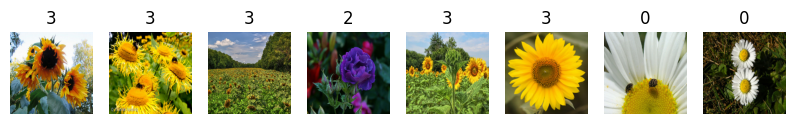

In [15]:
# Prendo un batch dal dataset di training (contiene fino a 32 immagini)
for imgs, labels in ds_train.take(1):
    # Creo una figura larga 10 pollici e alta 3 (proporzioni tipo striscia orizzontale)
    plt.figure(figsize=(10, 3))

    # Mostro le prime 8 immagini del batch
    for i in range(8):
        # Creo una griglia 1x8 (1 riga, 8 colonne) e seleziono la cella i+1
        plt.subplot(1, 8, i+1)
        
        # Tolgo gli assi (per vedere solo l’immagine, senza numeri/etichette)
        plt.axis('off')

        # Visualizzo l’immagine i-esima del batch
        # (è già un tensore 192x192 RGB, normalizzato tra 0 e 1 → perfetto per plt.imshow)
        plt.imshow(imgs[i])
        
        # Metto come titolo l’etichetta numerica corrispondente
        # (es: 0=daisy, 1=dandelion, 2=roses, 3=sunflowers, 4=tulips)
        plt.title(int(labels[i]))

    # Mostro la figura completa
    plt.show()

In [16]:
from tensorflow.keras import layers, models

# Modello sequenziale: i layer vengono aggiunti uno dopo l’altro in ordine lineare
model = models.Sequential([

    # --- FEATURE EXTRACTION (estrazione delle caratteristiche) ---
    
    # 1° livello convoluzionale:
    # - 16 filtri di dimensione 3x3
    # - activation='relu' introduce non-linearità
    # - input_shape specifica la forma dell’immagine in ingresso (192x192 RGB)
    layers.Conv2D(16, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # MaxPooling: riduce la dimensione spaziale (downsampling), mantenendo le informazioni più importanti.
    layers.MaxPool2D(),
    
    # 2° livello convoluzionale (più filtri = più capacità di riconoscere pattern complessi)
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPool2D(),

    # 3° livello convoluzionale (ancora più filtri per dettagli più astratti)
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPool2D(),

    # --- CLASSIFICAZIONE ---
    
    # Flatten: appiattisce le mappe di feature 2D → in un unico vettore 1D
    layers.Flatten(),
    
    # Strato denso (fully connected):
    # - 128 neuroni
    # - 'relu' per attivazione non lineare
    layers.Dense(128, activation='relu'),

    # Output layer:
    # - 5 neuroni (uno per ciascuna classe di fiore)
    # - 'softmax' restituisce una probabilità per ogni classe
    layers.Dense(5, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(
    # Ottimizzatore: "adam" è un algoritmo che aggiorna i pesi della rete neurale durante l’allenamento, cercando di minimizzare l’errore in modo efficiente.
    optimizer='adam',
    
    # Funzione di perdita (loss): "sparse_categorical_crossentropy"
    # - Si usa quando le etichette sono numeri interi (0,1,2,3,4) e NON one-hot.
    # - Confronta le probabilità prodotte dal modello con la classe corretta.
    loss='sparse_categorical_crossentropy',
    
    # Metriche da monitorare: "accuracy"
    # Mostra la percentuale di previsioni corrette sul dataset (sia in training che in validation).
    metrics=['accuracy']
)

In [18]:
# Mostra un riepilogo dettagliato della rete neurale:
# - Tipo e sequenza dei layer
# - Forma (dimensioni) degli input e output di ogni layer
# - Numero di parametri da addestrare (weights + bias)
# - Totale dei parametri (trainabili e non)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 190, 190, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 95, 95, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 93, 93, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Avvio l’addestramento del modello
history = model.fit(
    ds_train,               # dataset di training: usato per aggiornare i pesi del modello.
    validation_data=ds_val, # dataset di validazione: serve a controllare le prestazioni su dati mai visti durante l’allenamento.
    epochs=3                # numero di epoche = quante volte il modello vede tutto il dataset.
)

Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 65s 670ms/step - accuracy: 0.2934 - loss: 1.7627 - val_accuracy: 0.5490 - val_loss: 1.1108
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 662ms/step - accuracy: 0.5681 - loss: 1.0697 - val_accuracy: 0.6431 - val_loss: 0.9334
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 660ms/step - accuracy: 0.6387 - loss: 0.9217 - val_accuracy: 0.6771 - val_loss: 0.8469


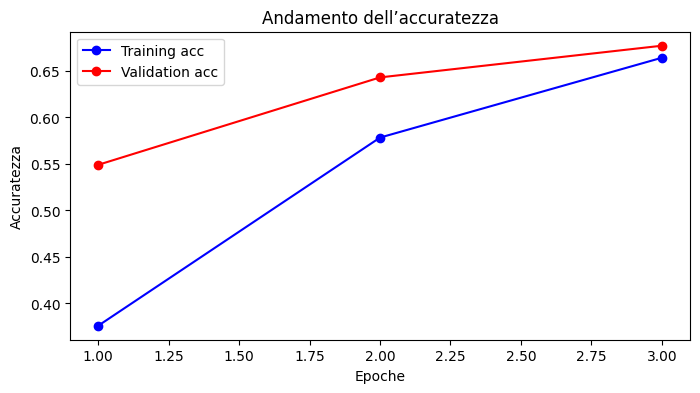

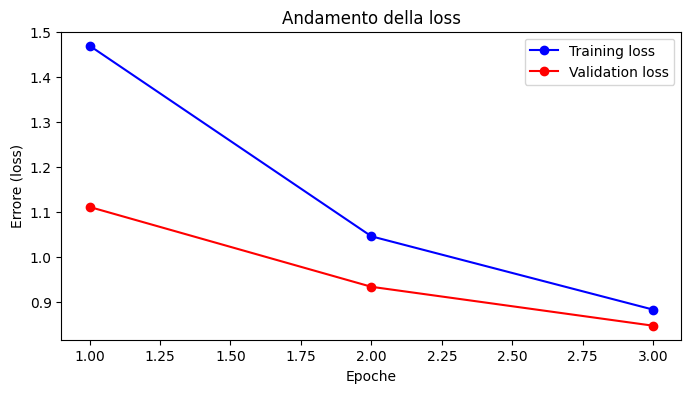

In [20]:
# Estraggo dal log di allenamento (history) le metriche registrate a ogni epoca
acc      = history.history['accuracy']        # accuratezza sul training set
val_acc  = history.history['val_accuracy']    # accuratezza sul validation set
loss     = history.history['loss']            # errore (loss) sul training set
val_loss = history.history['val_loss']        # errore (loss) sul validation set

# Creo un range [1..n] corrispondente alle epoche (1,2,3,...)
epochs = range(1, len(acc) + 1)

# ---------------------------
# Grafico dell'accuratezza
# ---------------------------
plt.figure(figsize=(8, 4))
plt.plot(epochs, acc, 'bo-', label='Training acc')        # linea blu con cerchietti
plt.plot(epochs, val_acc, 'ro-', label='Validation acc')  # linea rossa con cerchietti
plt.title('Andamento dell’accuratezza')
plt.xlabel('Epoche')
plt.ylabel('Accuratezza')
plt.legend()
plt.show()

# ---------------------------
# Grafico della loss (errore)
# ---------------------------
plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Andamento della loss')
plt.xlabel('Epoche')
plt.ylabel('Errore (loss)')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


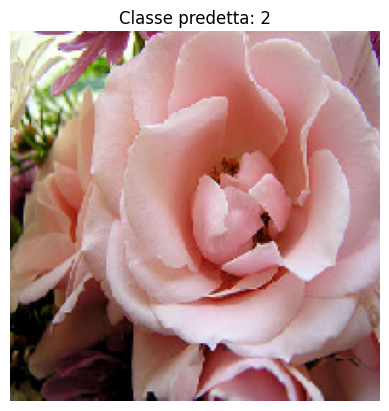

In [21]:
# Percorso di un'immagine di test (presa dal dataset)
img_path = "flower_photos/flower_photos/roses/12240303_80d87f77a3_n.jpg"

# ------------------------
# PREPROCESSING DELL'IMMAGINE
# ------------------------
# Carico l'immagine e la ridimensiono alla dimensione usata dal modello (192x192)
img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))

# Converto l'immagine in un array NumPy e normalizzo i valori [0..1]
img_array = img_to_array(img) / 255.0

# Aggiungo una dimensione in più per rappresentare il "batch"
# (il modello si aspetta input nella forma [batch, altezza, larghezza, canali])
img_array = np.expand_dims(img_array, axis=0)

# ------------------------
# PREDIZIONE
# ------------------------
# Uso il modello per fare una previsione: restituisce le probabilità per ciascuna classe
pred = model.predict(img_array)

# Scelgo la classe con probabilità più alta
pred_class = np.argmax(pred, axis=1)[0]

# ------------------------
# VISUALIZZAZIONE
# ------------------------
# Mostro l'immagine originale con la classe predetta come titolo
plt.imshow(img)
plt.axis("off")
plt.title(f"Classe predetta: {pred_class}")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


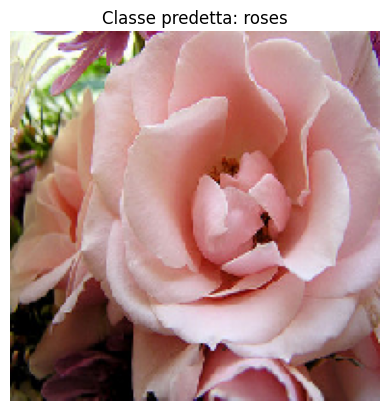

In [22]:
# ------------------------
# PREDIZIONE
# ------------------------
pred = model.predict(img_array)

# Ottengo l'indice della classe con probabilità maggiore (0..4)
pred_class = np.argmax(pred, axis=1)[0]

# Converto l'indice in etichetta testuale:
# - CLASSES contiene le label in formato byte (es. b'roses')
# - .numpy() le trasforma in stringa byte
# - .decode() le converte in stringa normale (es. "roses")
pred_label = CLASSES[pred_class].numpy().decode()

# ------------------------
# VISUALIZZAZIONE
# ------------------------
plt.imshow(img)
plt.axis("off")
plt.title(f"Classe predetta: {pred_label}")  # es. "Classe predetta: roses"
plt.show()

## ✅ Conclusioni

Abbiamo costruito un modello di classificazione di immagini in grado di distinguere tra diverse categorie di fiori.

**Cosa abbiamo imparato:**
-Come preparare un dataset di immagini per il training di una CNN.
-Come progettare, addestrare e valutare una rete convoluzionale con Keras.
-Come interpretare le metriche di accuratezza e perdita nel tempo.

Con più dati, una rete più profonda o tecniche di data augmentation e transfer learning, le prestazioni del modello possono migliorare ulteriormente.